### Import Library

<p>Langkah ini adalah untuk melakukan importing modul yang digunakan pada tahap preprocessing.<p>

In [2]:
import sys
import os

# Naik satu level ke folder utama proyek (Coding, sebelumnya folder preprocessing)
sys.path.append(os.path.abspath("..")) # Agar bisa import modul folder lain karena berada di root utama

In [3]:
from features_extraction.gabor import Gabor
from features_extraction.harralick import Harralick
from features_extraction.lbp import LBP
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2

Features_extraction package loaded!


In [4]:
import torch
import logging

### General Preprocessing

In [5]:
def general_preprocessing(image_path):
    # Load image
    image = cv2.imread(image_path)
    
    # Konversi ke grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Resize image
    resize_image = cv2.resize(gray_image, (128,128), interpolation=cv2.INTER_CUBIC)
    
    return resize_image

In [6]:
BASE_DIR = os.path.abspath("..")  # Naik satu level ke root proyek
# path ke dataset
dataset_path = os.path.join(BASE_DIR, "dataset") # Agar folder dataset dapat dibaca

In [ ]:
''' 
PROSES UNTUK CROPPING GAMBAR MENGGUNAKAN YOLOv5
'''

# Load model YOLOv5
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

# Loop melalui setiap folder (Overripe, Ripe, Unripe)
for folder_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder_name)
    
    # Pastikan folder_path adalah direktori
    if os.path.isdir(folder_path):
        # Buat folder untuk menyimpan hasil cropping jika belum ada
        output_folder = os.path.join(folder_path, "cropped")
        os.makedirs(output_folder, exist_ok=True)

        # Loop melalui setiap gambar dalam folder
        for filename in os.listdir(folder_path):
            if filename.endswith(('.jpg', '.jpeg', '.png')): 
                img_path = os.path.join(folder_path, filename)
                img = cv2.imread(img_path)

                # Jalankan inference dengan YOLOv5
                results = model(img)

                # Ekstrak bounding box
                detections = results.pandas().xyxy[0]
                for i in range(len(detections)):
                    x_min, y_min, x_max, y_max = map(int, detections.iloc[i][['xmin', 'ymin', 'xmax', 'ymax']])

                    # Crop gambar
                    cropped_img = img[y_min:y_max, x_min:x_max]

                    # Simpan gambar hasil crop
                    output_path = os.path.join(output_folder, f"{filename[:-4]}_cropped_{i}.jpg") 
                    cv2.imwrite(output_path, cropped_img)

In [7]:
# Kelas berdasarkan nama folder
classes = ["Overripe", "Ripe", "Unripe"]

# Menyimpan data gambar dan label
data = []
labels = []

# Iterasi setiap kelas
for label, category in enumerate(classes):
    folder_path = os.path.join(dataset_path, f'{category}/cropped')
    # print(folder_path)
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        # print(file_path)
        image = general_preprocessing(file_path)
        
        # Menyimpan data
        data.append(image)
        labels.append(label)

In [8]:
# Cek Jumlah label apakah sudah benar
for index, category in enumerate(classes):
    print(f"Jumlah label {category} adalah {labels.count(index)}")

Jumlah label Overripe adalah 144
Jumlah label Ripe adalah 183
Jumlah label Unripe adalah 168


In [9]:
# Konversi ke array NumPy
data = np.array(data, dtype="float32")
labels = np.array(labels)

print("Jumlah data:", len(data))
print("Jumlah label:", len(labels))

Jumlah data: 495
Jumlah label: 495


In [10]:
data.dtype

dtype('float32')

In [11]:
data = data.astype(np.uint8)

In [12]:
data.shape

(495, 128, 128)

In [13]:
print(f"Nilai piksel minimum: {np.min(data)}")
print(f"Nilai piksel maksimum: {np.max(data)}")

Nilai piksel minimum: 0
Nilai piksel maksimum: 255


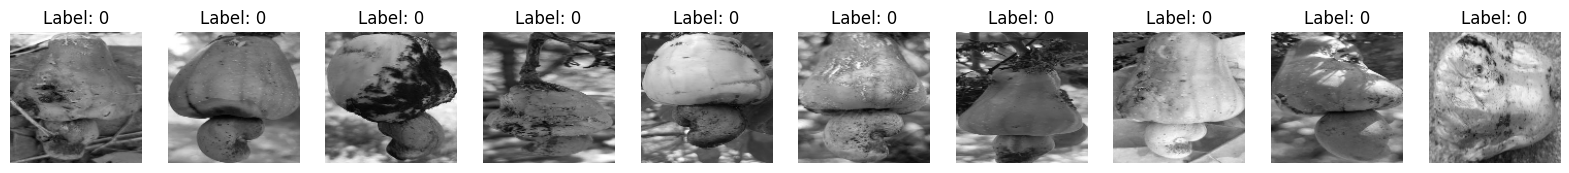

In [ ]:
# Menampilkan 10 contoh gambar pertama
num_samples = 10
plt.figure(figsize=(20, 10))

for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(data[i], cmap="gray")  # cmap="gray" agar sesuai dengan grayscale
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")

plt.show()